# EBI Metadata - General Insights

In [1]:
import pandas as pd

df = pd.read_csv('../data/metadata_EBI_preprocessed.csv',
                 dtype={'collected_by': object,
                        'collection_date': object,
                        'culture_collection': object,
                        'identified_by': object,
                        'isolate': object,
                        'isolation_source': object,
                        'keywords': object,
                        'lab_host': object,
                        'location': object,
                        'sample_accession': object,
                        'strain': object,
                        'study_accession': object})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520583 entries, 0 to 2520582
Data columns (total 34 columns):
 #   Column                Dtype  
---  ------                -----  
 0   accession             object 
 1   base_count            int64  
 2   collected_by          object 
 3   collection_date       object 
 4   country_and_region    object 
 5   culture_collection    object 
 6   dataclass             object 
 7   description           object 
 8   environmental_sample  bool   
 9   first_public          object 
 10  germline              bool   
 11  host                  object 
 12  identified_by         object 
 13  isolate               object 
 14  isolation_source      object 
 15  keywords              object 
 16  lab_host              object 
 17  last_updated          object 
 18  location              object 
 19  mol_type              object 
 20  sample_accession      object 
 21  scientific_name       object 
 22  sequence_md5          object 
 23  sequenc

## Descriptive Statistics

In [177]:
import pandas_profiling
import json

# Create fancy profile report
# See https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/advanced_usage.html for advanced usage
profile_ebi = pandas_profiling.ProfileReport(df,
                                             title='EBI Metadata Profiling',
                                             minimal=True,
                                             correlations={'pearson': {'calculate': True},
                                                           'spearman': {'calculate': True},
                                                           'kendall': {'calculate': True},
                                                           'phi_k': {'calculate': True},
                                                           'cramers': {'calculate': False}})

# Add definitions
with open('json_data/definitions_EBI_metadata.json') as f:
    definitions_ebi_metadata = json.load(f)
profile_ebi.config.variables.descriptions = definitions_ebi_metadata

# Save as html
profile_ebi.to_file(output_file='../data/metadata_EBI_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Investigation of National Bias

In [ ]:
# Separate dataframe into countries appearing often and rarely
threshold = 1000

rare_countries = df[df['country'].map(df['country'].value_counts()) < threshold]
rare_countries['country'].value_counts()

In [ ]:
popular_countries = df[df['country'].map(df['country'].value_counts()) >= threshold]
popular_countries['country'].value_counts()

In [ ]:
with open('json_data/country_inhabitants_map.json') as f:
    country_inhabitants_map = json.load(f)

In [2]:
import os

if not os.path.isdir('../plots/general_country_counts'):
    os.mkdir('../plots/general_country_counts')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Plot distribution of countries appearing more than 1,000 times
for hue in ['dataclass', 'mol_type', 'keywords', 'gender']:
    fig, ax = plt.subplots(figsize=(18, 16))
    sns.countplot(data=popular_countries,
                  x='country',
                  hue=hue,
                  order=popular_countries['country'].value_counts().index)

    fig.suptitle('Distribution of Countries with >= 1,000 Samples', fontsize=22)
    plt.xlabel('Country', fontsize=18)
    plt.ylabel('Count Normalized by Number of Inhabitants', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', title=f'{hue.capitalize()}:', fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14

    # Normalize height of bars with number of inhabitants
    max_y = 0
    n_countries = len(popular_countries['country'].unique())
    hue_index = 0

    for i, patch in enumerate(ax.patches):
        if i % n_countries == 0 and i != 0:
            hue_index += 1
        country = ax.get_xticklabels()[i - (hue_index * n_countries)].get_text()

        new_height = patch.get_height() / country_inhabitants_map[country]
        max_y = max(max_y, new_height)
        patch.set_height(new_height)

    plt.gca().set_ylim([0, max_y + (max_y / 20)])

    fig.savefig(f'../plots/general_country_counts/popular_countries_count_by_{hue}_normalized.png', dpi=300)
    plt.close()

In [ ]:
# Plot distribution of countries appearing less than 1,000 times
for hue in ['dataclass', 'mol_type', 'keywords', 'gender']:
    fig, ax = plt.subplots(figsize=(36, 18))
    sns.countplot(data=rare_countries,
                  x='country',
                  hue=hue,
                  order=rare_countries['country'].value_counts().index)

    fig.suptitle('Distribution of Countries with < 1,000 Samples', fontsize=22)
    plt.xlabel('Country', fontsize=18)
    plt.ylabel('Count Normalized by Number of Inhabitants', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', title=f'{hue.capitalize()}:', fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14

    # Normalize height of bars with number of inhabitants
    max_y = 0
    n_countries = len(rare_countries['country'].unique())
    hue_index = 0

    for i, patch in enumerate(ax.patches):
        if i % n_countries == 0 and i != 0:
            hue_index += 1
        country = ax.get_xticklabels()[i - (hue_index * n_countries)].get_text()

        if country == 'Unknown':
            new_height = 0.0
        else:
            new_height = patch.get_height() / country_inhabitants_map[country]

        max_y = max(max_y, new_height)
        patch.set_height(new_height)
    plt.gca().set_ylim([0, max_y + (max_y / 20)])

    fig.savefig(f'../plots/general_country_counts/rare_countries_count_by_{hue}_normalized.png', dpi=300)
    plt.close()

## Number of Infections per Country

In [157]:
# Taken from https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports/01-08-2022.csv
# Documentation at https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data#daily-reports-csse_covid_19_daily_reports
countries_hopkins = pd.read_csv('../data/countries_john_hopkins.csv')
countries_hopkins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4006 entries, 0 to 4005
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 3268 non-null   float64
 1   Admin2               3272 non-null   object 
 2   Province_State       3832 non-null   object 
 3   Country_Region       4006 non-null   object 
 4   Last_Update          4006 non-null   object 
 5   Lat                  3916 non-null   float64
 6   Long_                3916 non-null   float64
 7   Confirmed            4006 non-null   int64  
 8   Deaths               4006 non-null   int64  
 9   Recovered            0 non-null      float64
 10  Active               0 non-null      float64
 11  Combined_Key         4006 non-null   object 
 12  Incident_Rate        3915 non-null   float64
 13  Case_Fatality_Ratio  3967 non-null   float64
dtypes: float64(7), int64(2), object(5)
memory usage: 438.3+ KB


In [ ]:
# TODO

## Investigation of Temporal Bias

In [86]:
plotdata = df.copy(deep=True)
plotdata['collection_date'] = pd.to_datetime(plotdata['collection_date'])

In [ ]:
import os

if not os.path.isdir('../plots/n_samples_over_time'):
    os.mkdir('../plots/n_samples_over_time')

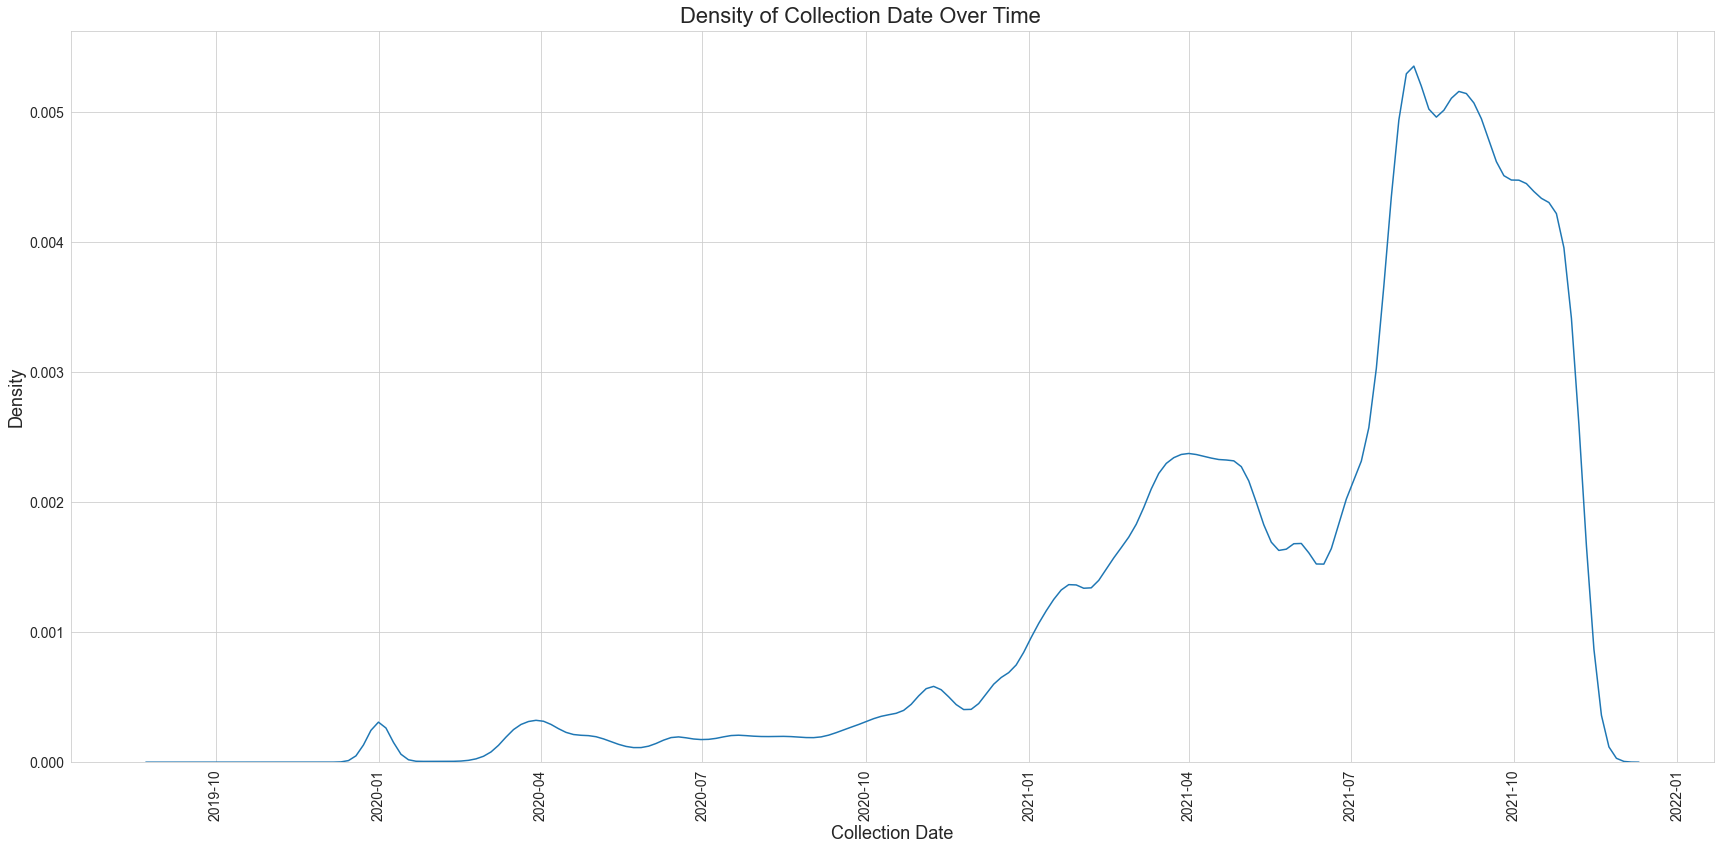

In [29]:
# A) Plot density
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 12))
sns.kdeplot(data=plotdata,
            x='collection_date') #,
            #hue='keywords')
fig.suptitle('Density of Collection Date Over Time', fontsize=22)
plt.xlabel('Collection Date', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/n_samples_over_time/collection_date_density.png', dpi=300)
plt.close()

In [87]:
# B) Plot absolute count
date_counts = plotdata.groupby(['collection_date']).count().sum(axis=1)
# date_counts = plotdata.groupby(['collection_date', 'keywords']).count().sum(axis=1)
date_counts = pd.DataFrame(date_counts, columns=['Count'])
date_counts.sort_values(by='Count', ascending=False)

,Count
collection_date,
2021-08-31,435713
2021-09-07,405527
2021-08-03,403332
2021-08-02,391875
2021-08-05,389234
...,...
2019-10-17,23
2019-09-12,23
2020-02-14,22


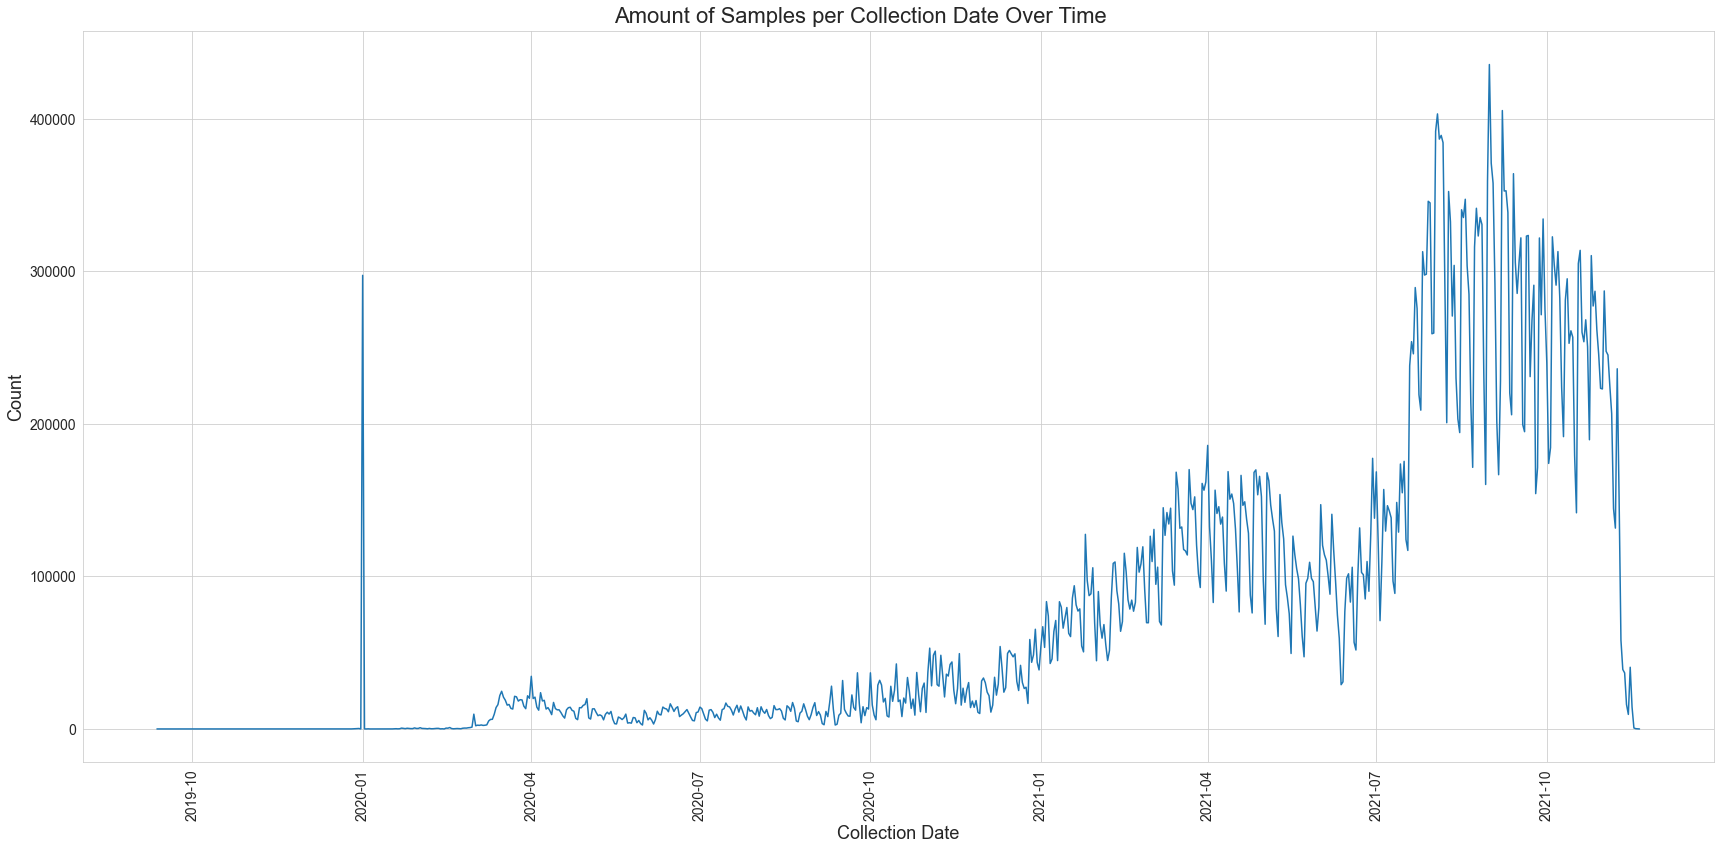

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 12))
sns.lineplot(x=date_counts.index, #.get_level_values(0),
             y=date_counts['Count']) #,
             #hue=date_counts.index.get_level_values(1))
fig.suptitle('Amount of Samples per Collection Date Over Time', fontsize=22)
plt.xlabel('Collection Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/n_samples_over_time/collection_date_count.png', dpi=300)
plt.close()

# -> temporal bias around April 2021 and Winter 2021
# -> amount of sequences was doubled in Winter in comparison to warmer months
# -> amount of sequences decreases in the end probably because original TSV is not up-to-date

In [88]:
# Filter for January 2020
date_counts[(date_counts.index.month == 1) & (date_counts.index.year == 2020)]

# -> a lot of sequences on New Year's Day 2020
# -> probably typo and 2021 is meant: UK had deflection around 9th January 2021 regarding number of cases
# -> but not explainable at all for Switzerland

,Count
collection_date,
2020-01-01,297473
2020-01-02,67
2020-01-03,23
2020-01-04,105
2020-01-05,23
2020-01-07,23
2020-01-08,66
2020-01-09,23
2020-01-10,47


In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot collection data count per country
for country in plotdata['country'].unique():
    plotdata_country = plotdata[plotdata['country'] == country]
    date_counts_country = plotdata_country.groupby(['collection_date']).count().sum(axis=1)
    date_counts_country = pd.DataFrame(date_counts_country, columns=['Count'])

    sns.set_style('whitegrid')
    fig, _ = plt.subplots(figsize=(24, 12))
    sns.lineplot(x=date_counts_country.index,
                 y=date_counts_country['Count'])
    fig.suptitle(f'Amount of Samples per Collection Date Over Time in {country}', fontsize=22)
    plt.xlabel('Collection Date', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    fig.savefig(f'../plots/n_samples_over_time/collection_date_count_{str(country).replace(" ", "_")}.png', dpi=300)
    plt.close()

# -> USA: raise of cases from end of October 2020 until February 2021 not recognisable
# -> UK: curve fits well
# -> Germany: same like for the USA + number of tests should be much higher since November 2021

## Investigation of Existing Ages

In [174]:
original_len = len(df)
original_len  # 2,520,583

2520583

In [38]:
# Count how many samples do contain (valuable) information about age
df_with_ages = df[df['age'].notna()]
len(df_with_ages)  # 9,948

9948

In [34]:
# Show how age is set for patients with age information given in days or months
df_with_ages[df_with_ages['host'].str.contains('day|months|mos|MOS')][['age', 'host']]

,age,host
993150,0.67,Homo sapiens; Male age 8 months
993264,0.33,Homo sapiens; Female age 4 months
993296,0.25,Homo sapiens; Male age 3 months
993677,0.14,Homo sapiens; Male age 50 days
993775,0.08,Homo sapiens; Female age 1 months
993802,0.83,Homo sapiens; Female age 10 months
993970,0.92,Homo sapiens; Female age 11 months
994025,0.58,Homo sapiens; Female age 7 months
994601,0.92,Homo sapiens; Female age 11 months
994679,0.42,Homo sapiens; Female age 5 months


In [140]:
# Check how host is set if age in not numeric and host is not equal to main value "homo sapiens" (for debugging and to finally check all set ages)
df['age'] = df['age'].astype(str)
non_numeric_ages = df[df['age'].apply(lambda x: not x.isnumeric())]
non_numeric_ages[non_numeric_ages['host'].str.lower() != 'homo sapiens'][['age', 'host']]

,age,host
460,nan,"Homo sapiens, female"
461,nan,"Homo sapiens, male"
462,nan,"Homo sapiens, male"
463,nan,"Homo sapiens, female"
464,nan,"Homo sapiens, male"
...,...,...
2242394,nan,NaN
2252312,nan,NaN
2474640,nan,not provided
2496096,nan,not provided


In [ ]:
# Convert ages to integers for simpler plotting
df_with_ages['age'] = df_with_ages['age'].astype(int)

In [41]:
# Sort by age
plotdata = df_with_ages.sort_values(by=['age'])

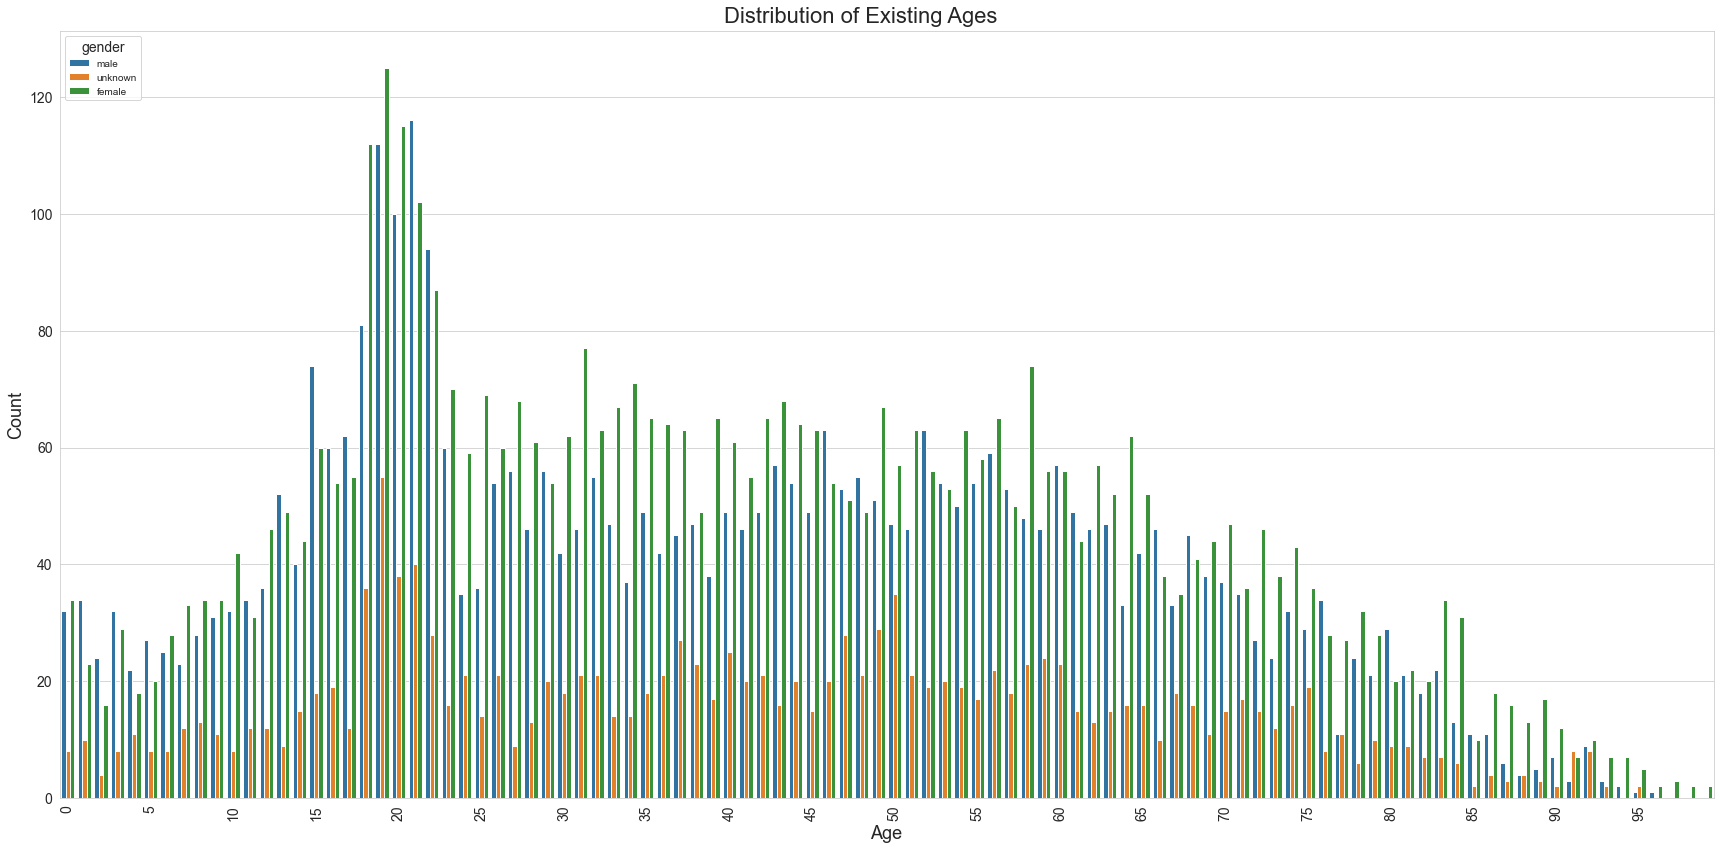

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 12))
sns.countplot(data=plotdata,
              x='age',
              hue='gender')
fig.suptitle('Distribution of Existing Ages', fontsize=22)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show only every 5th x-tick (aka every 5th age on x-axis)
for i, label in enumerate(ax.get_xticklabels()):
    if i % 5 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.tight_layout()
fig.savefig('../plots/age_distribution.png', dpi=300)
plt.close()

In [50]:
plotdata['country'].value_counts()

USA               9656
Russia             265
Italy               10
Czech Republic       6
Germany              5
China                5
Pakistan             1
Name: country, dtype: int64

In [ ]:
import os

if not os.path.isdir('../plots/age_distribution'):
    os.mkdir('../plots/age_distribution')

In [ ]:
# Ensure that age distribution won't change for USA and check if other countries show interesting distributions
for country, age_count in plotdata['country'].value_counts().iteritems():
    fig, ax = plt.subplots(figsize=(24, 12))
    sns.countplot(data=plotdata[plotdata['country'] == country],
                  x='age',
                  hue='gender')
    fig.suptitle(f'Distribution of Existing Ages in {country}\n ({age_count} ages available)', fontsize=22)
    plt.xlabel('Age', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Show only every 5th x-tick
    for i, label in enumerate(ax.get_xticklabels()):
        if i % 5 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.tight_layout()
    fig.savefig(f'../plots/age_distribution/age_distribution_{country}.png', dpi=300)
    plt.close()

# USA:
# -> similiar to real-world age distribution, especially regarding rise around 20
# -> see e.g. https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/
# -> a bit more female samples are also quite realistic

# RUSSIA:
# -> russian ages are mostly between 63 and 83